# Disease Tagging Tutorial

In this example, we'll be writing an application to extract *mentions of* diseases from Pubmed abstracts, using annotations from the [BioCreative CDR Challenge](http://www.biocreative.org/resources/corpora/biocreative-v-cdr-corpus/).  This tutorial, which has 5 parts, walks through the process of constructing a model to classify _candidate_ disease mentions as either true (i.e., that it is truly a mention of a disease) or false.

## Part II: `Candidate` Extraction

In [1]:
%load_ext autoreload
%autoreload 2

from snorkel import SnorkelSession
session = SnorkelSession()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Loading the `Corpus`

First, we will load the `Corpus` that we preprocessed in Part I:

In [2]:
from snorkel.models import Corpus

corpus = session.query(Corpus).filter(Corpus.name == 'CDR Training').one()
corpus

Corpus (CDR Training)

Next, we collect each `Sentence` in the `Corpus` into a `set`.

In [3]:
sentences = set()
for document in corpus:
    for sentence in document.sentences:
        sentences.add(sentence)

## Defining a `Candidate` schema
We now define the schema of the relation mention we want to extract (which is also the schema of the candidates).  This must be a subclass of `Candidate`, and we define it using a helper function.

Here we'll define a unary _disease relation mention_ which encapsulates a `Span` of text.  Note that this function will create the table in the database backend if it does not exist:

In [4]:
from snorkel.models import candidate_subclass

Disease = candidate_subclass('Disease', ['disease'])

## Writing a basic `CandidateExtractor`

Next, we'll write a basic function to extract **candidate relations mentions** from the corpus.  For this first attempt, we'll just write a function that checks for matches against several dictionaries at the _entity mention level_--i.e. looking for candidate chemical and disease mentions--and then considering any co-occuring pairs in the same sentence as candidate relation mentions.

We'll use some precomputed disease and chemical dictionaries (see `tutorial/data/dicts/compile_dictionaries.py` for details)

In [5]:
# Load the dictionaries
import pandas as pd
ROOT = 'data/dicts/'
diseases   = set(pd.read_csv(ROOT + 'disease_names.csv', header=None, index_col=0, encoding='utf-8').dropna()[1])
abbrvs  = set(pd.read_csv(ROOT + 'disease_abbrvs.csv', header=None, index_col=0, encoding='utf-8').dropna()[1])
body_parts  = set(pd.read_csv(ROOT + 'body_parts.csv', header=None, index_col=0, encoding='utf-8').dropna()[1])

We turn the dictionaries into a candidate extractor in three steps.

First, we define a child context space for our sentences.

In [6]:
from snorkel.candidates import Ngrams

ngrams = Ngrams(n_max=8, split_tokens=['-', '/'])

Next, we define two basic `DictionaryMatch` matchers to filter the child contexts based on the dictionaries.

In [7]:
from snorkel.matchers import DictionaryMatch

#
# DICTIONARIES
#
longest_match_only = True
dict_diseases = DictionaryMatch(d=diseases, ignore_case=True, 
                                longest_match_only=longest_match_only)
dict_abbrvs = DictionaryMatch(d=abbrvs, ignore_case=False, 
                              longest_match_only=longest_match_only)

We also build a third `DictionaryMatch` out of all stem words for later use.

In [8]:
keep = ["disease", "diseases", "syndrome", "syndromes", "disorder", 
        "disorders", "damage", "infection", "bleeding"]
stems = diseases | abbrvs | set(keep)
disease_stems = DictionaryMatch(d=stems, ignore_case=True, 
                                longest_match_only=longest_match_only)

Some diseases that we want to tag have common patterns indicating disease subtypes. We use a `Concat` matcher to match consecutive spans matched by its component matchers.

In [9]:
from snorkel.matchers import Concat

type_names = ['type', 'class', 'factor']
type_nums = ['i', 'ii', 'iii', 'vi', 'v', 'vi', '1a', 'iid', 'a', 'b', 'c', 'd'] 
type_nums += map(unicode,range(1,10))

types = Concat(DictionaryMatch(d=type_names),
               DictionaryMatch(d=type_nums))

disease_types_left = Concat(types, disease_stems)
disease_types_right = Concat(disease_stems, types)

We can make complex patterns with `Concat` and `DictionaryMatch` matchers.

In [10]:
disease_pattern = ["disease", "diseases", "syndrome", "syndromes", "disorder", "disorders", "damage", "infection", 
       "lesion", "lesions", "impairment", "impairments", "failure", "failures", "occlusion", "occlusions", 
       "dysfunction", "dysfunctions", "toxicity", "injury", "carcinoma", "carcinomas", "thrombosis", "cancer", 
       "cancers", "block", "pain"]

timestamp = ["end-stage", "acute", "chronic", "congestive"]

conjunction = ["and", "or", "and/or"]

stemmer='porter'
body_disease = Concat(Concat(DictionaryMatch(d=body_parts, longest_match_only=longest_match_only, stemmer=stemmer), 
                             DictionaryMatch(d=conjunction, longest_match_only=longest_match_only)), 
                      Concat(DictionaryMatch(d=timestamp, longest_match_only=longest_match_only), 
                             Concat(DictionaryMatch(d=body_parts, longest_match_only=longest_match_only, stemmer=stemmer), 
                                    DictionaryMatch(d=disease_pattern, longest_match_only=longest_match_only, stemmer=stemmer)), left_required=False), left_required=False)

We create a `Union` of the `Matcher` objects, to produce a final `Matcher` that matches any input that any one of its component matchers does.

In [11]:
from snorkel.matchers import Union

disease_matcher = Union(disease_types_left, disease_types_right, dict_diseases, dict_abbrvs, body_disease,
                        longest_match_only=longest_match_only)

Finally, we combine the candidate class, child context space, and matcher into an extractor.

In [12]:
from snorkel.candidates import CandidateExtractor

ce = CandidateExtractor(Disease, [ngrams], [disease_matcher])

## Running the `CandidateExtractor`

We run the `CandidateExtractor` by calling extract with the contexts to extract from, a name for the `CandidateSet` that will contain the results, and the current session.

In [13]:
%time c = ce.extract(sentences, 'CDR Training Candidates', session)
print "Number of candidates:", len(c)

[========================================] 100%

CPU times: user 7min 39s, sys: 1min 3s, total: 8min 42s
Wall time: 7min 56s
Number of candidates: 5981


### Saving the extracted candidates

In [14]:
session.add(c)
session.commit()

### Reloading the candidates

In [15]:
from snorkel.models import CandidateSet
c = session.query(CandidateSet).filter(CandidateSet.name == 'CDR Training Candidates').one()
c

Candidate Set (CDR Training Candidates)

# Load the gold candidates

In [101]:
gold_candidate_set = session.query(CandidateSet).filter(CandidateSet.name == 'CDR Training Candidates -- Gold').one()
len(gold_candidate_set)

4182

# Getting a sense of the (unary) candidate extraction problem

Starting by getting total count of *candidate* candidates...

In [20]:
from snorkel.models import Candidate
from snorkel.utils import ProgressBar

num_ccs = 0
pb = ProgressBar(len(sentences))
for i,s in enumerate(sentences):
    pb.bar(i)
    for tc in ngrams.apply(s):
        num_ccs += 1
pb.close()
print "Total # of potential candidates:", num_ccs

[========================================] 100%

Total # of potential candidates: 746759


In [21]:
len(c) / float(num_ccs)

0.00800927742417567

## Now, we'll get matcher / LF stats

In [26]:
import re
from lf_terms import *
from snorkel.lf_helpers import get_left_tokens, get_right_tokens

In [28]:
from utils import *

umls_dict              = load_umls_dictionary()
chemicals              = load_chemdner_dictionary()
abbrv2text, text2abbrv = load_specialist_abbreviations()

In [29]:
from snorkel.lf_helpers import get_doc_candidate_spans

def LF_undefined_abbreviation(c):
    '''Candidate is a known abbreviation, but no corresponding full name in document'''
    doc_spans = get_doc_candidate_spans(c)
    phrase = c[0].get_span().lower()
    mentions = set([s.get_span().lower() for s in doc_spans])
    if len(phrase) > 1 and phrase in abbrv2text and not set(abbrv2text[phrase].keys()).intersection(mentions):
        return -1
    return 0

In [30]:
from snorkel.lf_helpers import get_sent_candidate_spans

def LF_contiguous_mentions(c):
    '''Contiguous candidates are likely wrong'''
    neighbor_spans = get_sent_candidate_spans(c)
    start, end = c[0].get_word_start(), c[0].get_word_end()
    for s in neighbor_spans:
        if s.get_word_end() + 1 == start or s.get_word_start() - 1 == end:
            return -1
    return 0

In [31]:
from snorkel.lf_helpers import get_left_tokens, get_right_tokens

def LF_tumors_growths(c):
    phrase = " ".join(c[0].get_attrib_tokens('lemmas'))
    return 1 if re.search("^(\w* ){0,2}(['] )*(tumor|tumour|polyp|pilomatricoma|cyst|lipoma)$", phrase) else 0

def LF_cancer(c):
    '''<TYPE> cancer'''
    phrase = " ".join(c[0].get_attrib_tokens('lemmas'))
    return 1 if re.search("\w* cancer",phrase) else 0

def LF_disease_syndrome(c):
    '''<TYPE> disease or <TYPE> syndrome'''
    phrase = " ".join(c[0].get_attrib_tokens('lemmas'))
    return 1 if re.search("\w* (disease|syndrome)+",phrase) else 0

def LF_indicators(c):
    '''Indicator words'''
    return 1 if " ".join(c[0].get_attrib_tokens()).lower() in indicators else 0

def LF_common_disease(c):
    '''Common disease'''
    return 1 if " ".join(c[0].get_attrib_tokens()).lower() in common_disease else 0

In [32]:
def LF_SNOWMED_CT_sign_or_symptom(c):
    return 1 if c[0].get_span() in umls_dict["snomedct"]["sign_or_symptom"] else 0

def LF_SNOWMED_CT_disease_or_syndrome(c):
    return 1 if c[0].get_span() in umls_dict["snomedct"]["disease_or_syndrome"] else 0

def LF_MESH_disease_or_syndrome(c):
    return 1 if c[0].get_span() in umls_dict["mesh"]["disease_or_syndrome"] else 0

def LF_MESH_sign_or_symptom(c):
    return 1 if c[0].get_span() in umls_dict["mesh"]["sign_or_symptom"] else 0

In [33]:
def LF_organs(c):
    phrase = " ".join(c[0].get_attrib_tokens()).lower()
    return -1 if phrase in organs else 0      

def LF_chemical_name(c):
    phrase = " ".join(c[0].get_attrib_tokens())
    return -1 if phrase in chemicals and not phrase.isupper() else 0

def LF_bodysym(c):
    phrase = " ".join(c[0].get_attrib_tokens()).lower()
    return -1 if phrase in bodysym else 0  

def LF_protein_chemical_abbrv(c):
    '''Gene/protein/chemical name'''
    lemma = " ".join(c[0].get_attrib_tokens('lemmas'))
    return -1 if re.search("\d+",lemma) else 0

def LF_base_pair_seq(c): 
    lemma = " ".join(c[0].get_attrib_tokens('lemmas'))
    return -1 if re.search("^[GACT]{2,}$",lemma) else 0

In [46]:
from CDR_Tutorial_LFs import *

LFs_doc = [LF_undefined_abbreviation]

LFs_sent = [LF_contiguous_mentions]

LFs_mention = [LF_tumors_growths,
               LF_cancer,
               LF_disease_syndrome,
               LF_indicators,
               LF_common_disease,
               LF_common_disease_acronyms,
               LF_deficiency_of,
               LF_positive_indicator,
               LF_left_positive_argument,
               LF_right_negative_argument,
               LF_medical_afixes,
               LF_adj_diseases
              ]

LFs_dicts =  [LF_SNOWMED_CT_sign_or_symptom,
              LF_SNOWMED_CT_disease_or_syndrome,
              LF_MESH_disease_or_syndrome,
              LF_MESH_sign_or_symptom
            ]

LFs_false = [LF_chemical_name,
             LF_organs,
             LF_bodysym,
             LF_protein_chemical_abbrv,
             LF_base_pair_seq,
             LF_too_vague,
             LF_neg_surfix,
             LF_non_common_disease,
             LF_non_disease_acronyms,
             LF_pos_in,
             LF_gene_chromosome_link,
             LF_right_window_incomplete,
             LF_negative_indicator
            ]

LFs = LFs_doc + LFs_sent + LFs_mention + LFs_dicts + LFs_false
len(LFs)

31

In [102]:
MATCHERS = [
    disease_types_left,
    disease_types_right,
    dict_diseases, 
    dict_abbrvs,
    body_disease,
]
len(MATCHERS)

5

In [108]:
from snorkel.models import Candidate, Context

def get_stats(matchers, lfs, sentences):
    matcher_precision = np.zeros(len(matchers))
    matcher_totals    = np.zeros(len(matchers))
    lf_precision      = np.zeros(len(lfs))
    lf_totals         = np.zeros(len(lfs))

    pb = ProgressBar(len(sentences))
    for i,s in enumerate(sentences):
        pb.bar(i)
        for tc in ngrams.apply(s):
            any_matches = False
        
            # Test the matchers
            for j,m in enumerate(matchers):
                if m.f(tc):
                    any_matches        = True
                    matcher_totals[j] += 1
            
            # Test the LFs
            for j,lf in enumerate(lfs):
                if lf([tc]):
                    any_matches   = True
                    lf_totals[j] += 1
                
            # Find out if in the gold set, if there were any matches!
            if any_matches:
                q = session.query(Disease.id).join(Context)
                q = q.filter(Context.id == Disease.disease_id)
                q = q.filter(Context.stable_id == tc.get_stable_id())
                q = q.filter(Candidate.sets.contains(gold_candidate_set))
                if q.first() is not None:
                    for j,m in enumerate(matchers):
                        if m.f(tc):
                            matcher_precision[j] += 1
                    for j,lf in enumerate(lfs):
                        if lf([tc]):
                            lf_precision[j] += 1
    pb.close()

    lf_precision = lf_precision / lf_totals
    return matcher_precision, matcher_totals, lf_precision, lf_totals

In [ ]:
matcher_precision, matcher_totals, lf_precision, lf_totals = get_stats(MATCHERS, LFs, sentences)

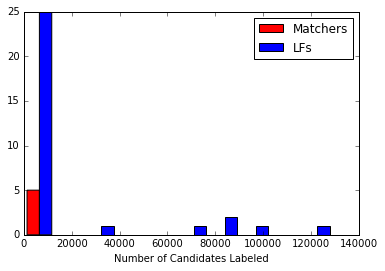

In [88]:
plt.figure()
plt.hist((matcher_totals, lf_totals), color=['red', 'blue'], label=['Matchers', 'LFs'])
plt.xlabel("Number of Candidates Labeled")
plt.legend()

# Print list of LF names
#sorted(zip([lf.__name__ for lf in LFs], lf_totals), key=lambda x : -x[1])

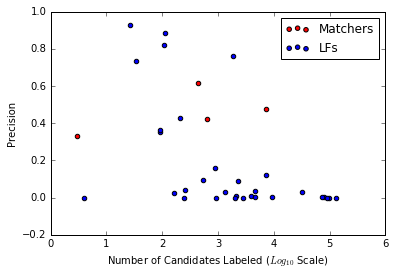

In [100]:
plt.figure()
plt.scatter(x=np.log10(matcher_totals), y=matcher_precision, c='red', label='Matchers')
plt.scatter(x=np.log10(lf_totals), y=lf_precision, label='LFs')
plt.xlabel("Number of Candidates Labeled ($Log_{10}$ Scale)")
plt.ylabel("Precision")
plt.legend()